<a href="https://colab.research.google.com/github/Andre-Natu/Tradu-o-lingua-de-sinais/blob/main/Prova_2_I_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importação e visualização da base de dados

In [276]:
# Importação de todas as bibliotecas usadas durante o código
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
from pathlib import Path
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.model_selection import GroupKFold, RandomizedSearchCV, StratifiedGroupKFold, cross_val_score, cross_val_predict
from sklearn.metrics import make_scorer, accuracy_score, f1_score, silhouette_score, davies_bouldin_score, calinski_harabasz_score, confusion_matrix
from scipy.stats import uniform, randint

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering

In [250]:
# Permissão para acessar o arquivo do Google Drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [251]:
# transformando a base de dados para um dataframe Pandas'
data = pd.read_csv("/content/drive/MyDrive/Database Sinais/sinais.csv")
data.head(100)

,file_name,width,height,duration_sec,num_frames,sinal,interprete
0,Adição_AP_10.json,738,1008,4.533333,136,Adição,Alexson
1,Adição_AP_1.json,774,1006,4.766667,143,Adição,Alexson
2,Adição_AP_2.json,760,1002,4.433333,133,Adição,Alexson
3,Adição_AP_3.json,762,1000,4.933333,148,Adição,Alexson
4,Adição_AP_4.json,764,1004,4.600000,138,Adição,Alexson
...,...,...,...,...,...,...,...
95,Coerência_AP_4.json,876,972,5.066667,152,Coerência,Alexson
96,Coerência_AP_5.json,886,966,4.533333,136,Coerência,Alexson
97,Coerência_AP_6.json,856,960,5.600000,168,Coerência,Alexson
98,Coerência_AP_7.json,864,958,4.833333,145,Coerência,Alexson


# Pre-Processamento

In [252]:
# removendo colunas desnecessárias para a aplicação.
data.drop(columns=["duration_sec", "num_frames"],
          errors="ignore", inplace=True)
data

,file_name,width,height,sinal,interprete
0,Adição_AP_10.json,738,1008,Adição,Alexson
1,Adição_AP_1.json,774,1006,Adição,Alexson
2,Adição_AP_2.json,760,1002,Adição,Alexson
3,Adição_AP_3.json,762,1000,Adição,Alexson
4,Adição_AP_4.json,764,1004,Adição,Alexson
...,...,...,...,...,...
2497,Ângulo_TS_5.json,398,624,Ângulo,Tiago
2498,Ângulo_TS_6.json,396,622,Ângulo,Tiago
2499,Ângulo_TS_7.json,398,624,Ângulo,Tiago
2500,Ângulo_TS_8.json,388,622,Ângulo,Tiago


## Removendo Valores nulos e verificando duplicatas

In [253]:
nulos = data.isnull().sum()
print(nulos)

file_name     1
width         0
height        0
sinal         0
interprete    0
dtype: int64


In [254]:
data.dropna(inplace=True)
nulos = data.isnull().sum()
print(nulos)

file_name     0
width         0
height        0
sinal         0
interprete    0
dtype: int64


In [255]:
#Conta quantas ocorrências de duplicatas exatas nos dados
duplicatas = data[data.duplicated()]

duplicatas.shape

(0, 5)

## Transformando os arquivos .json numa base de dados e Redução de Dimensionalidade usando seleção de atributos.

De acordo com deduções críticas analisando o pdf Descrição do Corpus de Keyframes em Libras e testando trocando os valores. Foi descoberto que pegar apenas os keyframes de id 9 até o 22 gerou os melhores resultados. Isso porquê os outros keyframes não influenciavam tanto para a previsão e contavam mais como ruído. Eu também retirei o campo de visibility e o z, pois de acordo com os testes e análise crítica, eles não contribuiam muito para as previsões.

Além disso, colocar todos os frames como colunas geraria uma quantidade absurda de colunas, além de que cada json possui uma quantidade de frames diferente, o que geraria várias colunas nulas e tamanhos diferentes uma das outras. Para circundar essa questão, optei para dividir os frames em grupos de 10, pegando a média, variância e desvio padrão deles. Assim é possível juntar em grupos e compara-los.

Por último, como cada json possui uma resolução diferente ( valor de width e height diferente), foi necessário dividir os valores de x e y pela width e height respectivamente, para "normaliza-los" em relação aos outros valores de x e y de outros arquivos json, que possuiam resolução diferente. Assim é possível comparar os valores de arquivos diferentes.

In [256]:
def extract_features_from_json(path, width, height):
    with open(path) as f:
        data = json.load(f)

    # Inicializa estrutura somente para ids 9–22
    coords = { (i, c): [] for i in range(9, 23) for c in ['x', 'y'] }

    # Percorre frames e normaliza apenas ids entre 9 e 22
    for frame in data['frames']:
        for kp in frame['keypoints']:
            i = kp['id']
            if 9 <= i < 23:
                coords[(i, 'x')].append(kp['x'] / width)
                coords[(i, 'y')].append(kp['y'] / height)

    # Cria features por 8 divisões de frames
    features = {}
    for (i, c), vals in coords.items():
        arr = np.array(vals)
        n = len(arr)
        # Calcula índices de corte para 8 divisões
        splits = np.array_split(arr, 8)
        for idx, part in enumerate(splits, start=1):
            features[f'id{i}_{c}_mean_part{idx}']   = part.mean()
            features[f'id{i}_{c}_std_part{idx}']    = part.std()
            features[f'id{i}_{c}_var_part{idx}']    = part.var()

    return features

For que lê o file_name da base de dados e chama a função que transforma ele em json e em seguida adiciona a coluna sinail e interprete para a nova base de dados.

In [257]:
meta = pd.read_csv("/content/drive/MyDrive/Database Sinais/sinais.csv")
all_features = []
caminho_fixo = "/content/drive/MyDrive/Database Sinais/Sinais/"

for _, row in meta.iterrows():
    if isinstance(row.file_name, str):
        # Passa width e height para normalizar
        feats = extract_features_from_json(Path(caminho_fixo + row.file_name), row.width, row.height)
        feats['Sinal'] = row.sinal
        feats['interprete'] = row.interprete
        all_features.append(feats)


df = pd.DataFrame(all_features)
df

,id9_x_mean_part1,id9_x_std_part1,id9_x_var_part1,id9_x_mean_part2,id9_x_std_part2,id9_x_var_part2,id9_x_mean_part3,id9_x_std_part3,id9_x_var_part3,id9_x_mean_part4,...,id22_y_std_part6,id22_y_var_part6,id22_y_mean_part7,id22_y_std_part7,id22_y_var_part7,id22_y_mean_part8,id22_y_std_part8,id22_y_var_part8,Sinal,interprete
0,0.605293,0.000617,3.811893e-07,0.604814,0.000923,8.513227e-07,0.612944,0.002708,7.331541e-06,0.610792,...,0.120902,1.461718e-02,0.807481,0.001462,0.000002,0.804038,0.000770,5.925573e-07,Adição,Alexson
1,0.606015,0.001254,1.571350e-06,0.606733,0.000630,3.967015e-07,0.605369,0.001984,3.936103e-06,0.617069,...,0.134811,1.817395e-02,0.819748,0.004937,0.000024,0.812069,0.001103,1.217184e-06,Adição,Alexson
2,0.606889,0.000848,7.188797e-07,0.606579,0.000000,0.000000e+00,0.609133,0.003510,1.231681e-05,0.624458,...,0.104395,1.089830e-02,0.766779,0.042321,0.001791,0.798840,0.000787,6.186168e-07,Adição,Alexson
3,0.614380,0.000641,4.102809e-07,0.613690,0.000633,4.007395e-07,0.618939,0.006275,3.937743e-05,0.621080,...,0.141446,2.000710e-02,0.802333,0.001333,0.000002,0.801167,0.000833,6.944444e-07,Adição,Alexson
4,0.606457,0.000617,3.807157e-07,0.607184,0.001225,1.501712e-06,0.608023,0.001497,2.240821e-06,0.618802,...,0.074825,5.598760e-03,0.769862,0.055668,0.003099,0.808413,0.000833,6.934036e-07,Adição,Alexson
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2496,0.529264,0.002101,4.412527e-06,0.534732,0.000958,9.174561e-07,0.532516,0.001605,2.577615e-06,0.530151,...,0.008149,6.640027e-05,0.739913,0.121321,0.014719,0.904247,0.004689,2.199031e-05,Ângulo,Tiago
2497,0.535354,0.000000,0.000000e+00,0.536458,0.001253,1.569315e-06,0.533144,0.002341,5.480149e-06,0.524937,...,0.019086,3.642888e-04,0.736013,0.096188,0.009252,0.900429,0.005736,3.290105e-05,Ângulo,Tiago
2498,0.532820,0.001654,2.737265e-06,0.535333,0.000608,3.699007e-07,0.534673,0.001880,3.535264e-06,0.531491,...,0.000785,6.163708e-07,0.622756,0.103239,0.010658,0.884295,0.018764,3.520847e-04,Ângulo,Tiago
2499,0.530445,0.001006,1.011955e-06,0.532055,0.001279,1.634697e-06,0.530756,0.000643,4.133159e-07,0.521306,...,0.002844,8.087408e-06,0.532905,0.039681,0.001575,0.805466,0.072925,5.318045e-03,Ângulo,Tiago


## Verificando se a proporção das classes se manteve e justificativa de não apliação do SMOTE

Podemos ver atravéz do gráfico, que as classes da base de dados são bem balanceadas, e por tanto não há necessidade de aplicar algum algoritmo para balanceamento de classes como o SMOTE.

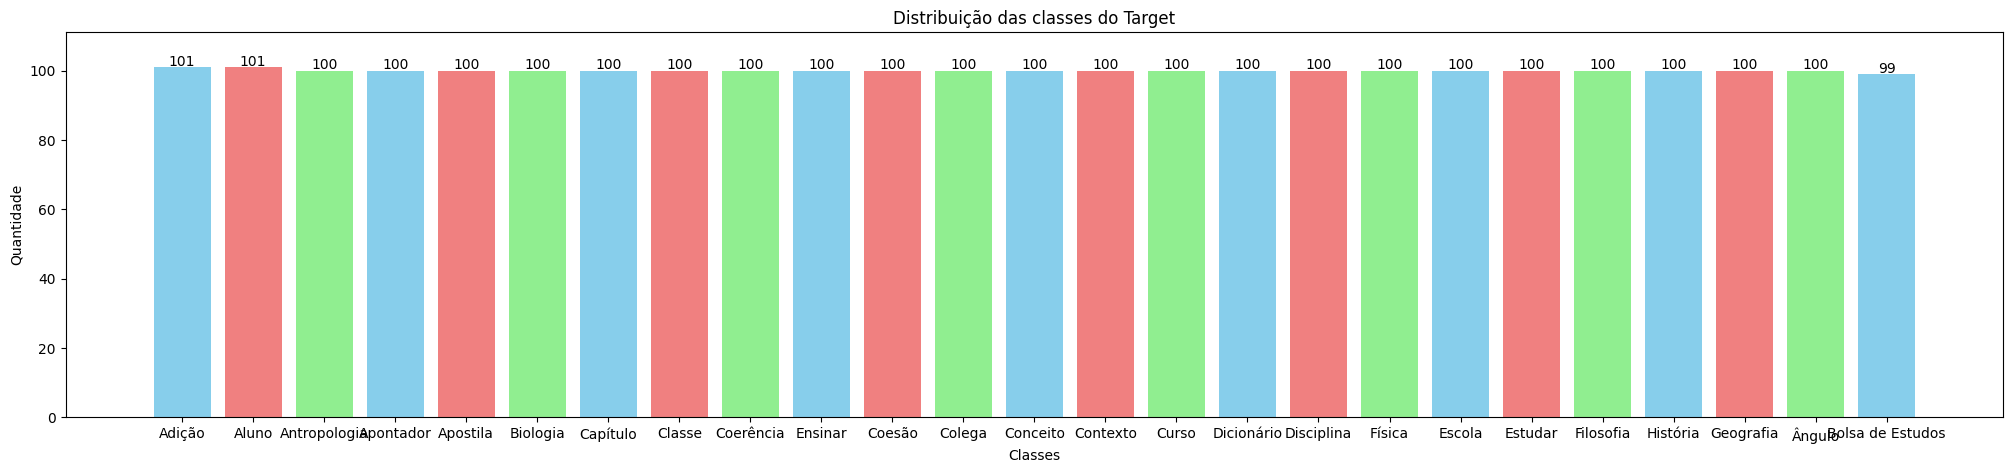

In [258]:
# Conta quantas instâncias de cada classe tem na base de dados.
dist_count = df.value_counts("Sinal")

plt.figure(figsize=(25, 5))
cores = ['skyblue', 'lightcoral', 'lightgreen'][:len(dist_count)]

plt.bar(dist_count.index.astype(str), dist_count.values, color=cores)

# Rótulos de valores no topo
for i, v in enumerate(dist_count.values):
    plt.text(i, v + 0.5, str(v), ha='center')

plt.title('Distribuição das classes do Target')
plt.xlabel('Classes')
plt.ylabel('Quantidade')
plt.ylim(0, dist_count.max() * 1.1)  # pequena folga no topo
plt.show()

# Aplicando o RandomForest

Divindo a base de dados em features e target e em seguida aplicando o label encoder na target.

In [259]:
# 1. Definir o nome da coluna alvo
target_column = 'Sinal'

# 2. Separar X e y
y = df[target_column]
X = df.drop(columns=[target_column, "interprete"])

# Aplicando LabelEncoder para a variável alvo.
le = LabelEncoder()
y = le.fit_transform(y)

y

array([ 0,  0,  0, ..., 24, 24, 24])

## RandomizedSearchCV para encontrar os melhores parâmetros para o RandomForest

In [260]:
# 3. Definir grupos
groups = df['interprete']

# 4. Definir GroupKFold
gkf = GroupKFold(n_splits=5)

# 5. Definir modelo base
model = RandomForestClassifier(random_state=79)

# 6. Definir grade de parâmetros para RandomizedSearchCV
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# 7. Criar RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=20,                   # número de combinações aleatórias a testar
    scoring='accuracy',
    cv=gkf,                      # passa o GroupKFold
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# 8. Ajustar o modelo com RandomizedSearchCV
random_search.fit(X, y, groups=groups)

# 9. Resultados
print("Melhores parâmetros:", random_search.best_params_)
print("Melhor score:", random_search.best_score_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Melhores parâmetros: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30}
Melhor score: 0.5106363273453094


## Aplicando o Stratify Group K Fold

O Group K Fould foi necessário para ser aplicado, porquê apenas o k fold fazia com que o código tivesse overfitting. isso porquê tanto o teste quando o treino tinham acesso aos mesmos interpretes. isso fazia com que o algoritmo entendese os padrões de cada interprete e foca-se o algoritmo em reconhecer os padrões de cada interprete ao invéz dos sinais. Ao chamar o group K fold, separando os folds em interpretes, de forma que em um determinado momento jamais tenha um interprete tanto quanto no teste quanto no treino, é possível ver o desempenho real do algoritmo em situações mais generalistas.

In [263]:
# 3. Definir grupos
groups = df['interprete']

# 4. Criar StratifiedGroupKFold
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=79)

# Para poder analisar o modelo com f1
f1_macro = make_scorer(f1_score, average='macro')  # ou 'weighted', 'micro'

# 5. Modelo
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    n_jobs = -1,
    criterion='entropy',
    random_state=79
)

# 6. Cross-validation com StratifiedGroupKFold
scores = cross_val_score(
    model,
    X,
    y,
    cv=sgkf,
    scoring="accuracy",
    groups=groups  # importante para respeitar os intérpretes
)

print("Scores Acurácia:", scores)
print("Média Acurácia:", scores.mean())

Scores Acurácia: [0.688      0.69461078 0.27       0.482      0.45      ]
Média Acurácia: 0.5169221556886228


## Matriz de confusão e f1 score.

F1-score: 0.5202940782348849


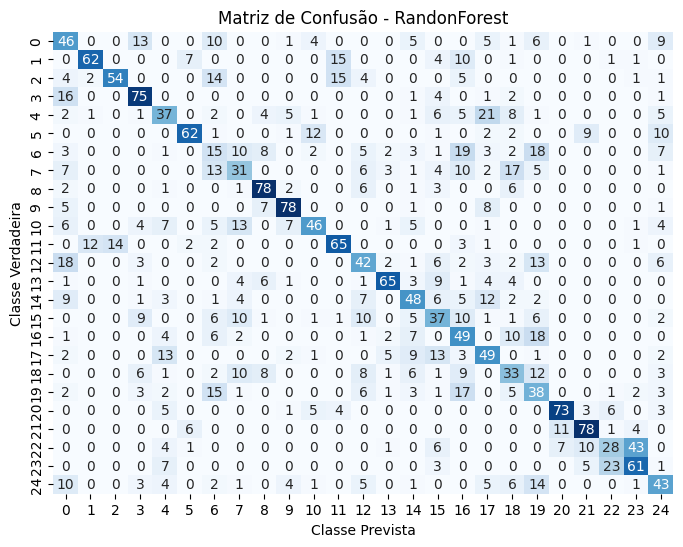

In [285]:
# Chamando o cross_val_predict é possível obter o y_pred e usar ele para criar a
# matriz de confusão.
y_pred_rf = cross_val_predict(
    model,
    X,
    y,
    cv=sgkf,
    groups=groups,
    method='predict_proba'
)

# Como é não é um problema binario, não é possível usar o f1 normal. Por isso
# estou usando f1 macro.
f1_macro = f1_score(y, np.argmax(y_pred_rf, axis=1), average='macro')
print("F1-score:", f1_macro)

# Calculando a Matriz de confusão
conf_mat = confusion_matrix(y, np.argmax(y_pred_rf, axis=1)) # Calculate confusion matrix on predicted classes

# Plotando o gráfico da matriz de confusão
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.title('Matriz de Confusão - RandonForest')
plt.xlabel('Classe Prevista')
plt.ylabel('Classe Verdadeira')
plt.show()

## Aplicando o K-NN

In [269]:
# 1. Definir o nome da coluna alvo
target_column = 'Sinal'

# 2. Separar X e y
y = df[target_column]
X = df.drop(columns=[target_column, "interprete"])

# Aplicando LabelEncoder para a variável alvo.
le = LabelEncoder()
y = le.fit_transform(y)

y

array([ 0,  0,  0, ..., 24, 24, 24])

Como o Knn e o MLP precisam que a base de dados esteja normalizada. Eu criei um pipe que normaliza a base de dados e aproveitei o momento para aplicar redução de dimensionalidade com PCA.

In [270]:
# --------- Modelo com PCA ---------
knn = KNeighborsClassifier(n_neighbors=5)

# Pipeline para padronizar e aplicar PCA
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),  # mantém 95% da variância
    ('knn', knn)
])

groups = df["interprete"]

sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=79)

# --------- Accuracy por fold ---------
scores = cross_val_score(
    pipe,
    X,
    y,
    cv=sgkf,
    groups=groups,
    scoring='accuracy'
)

print("Accuracy por fold:", np.round(scores, 4))
print("Média accuracy:", scores.mean())

Accuracy por fold: [0.422 0.485 0.104 0.216 0.252]
Média accuracy: 0.2958059880239521


F1-score macro: 0.3090866983504629


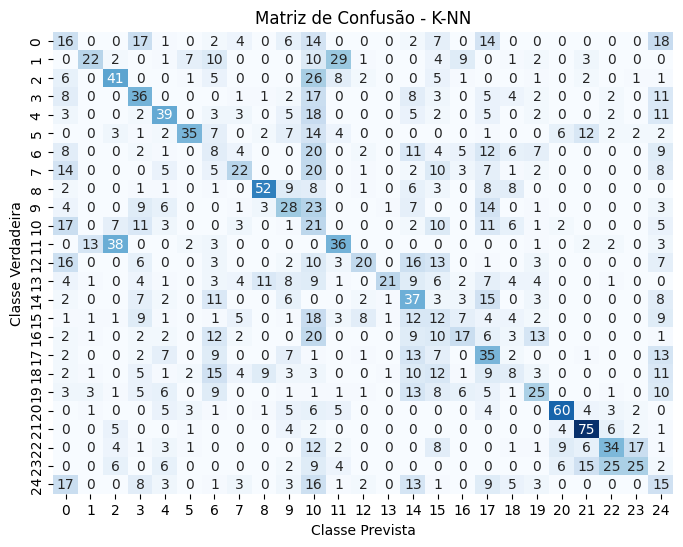

In [271]:
# Obtendo as previsões do modelo
y_pred_knn = cross_val_predict(
    pipe,
    X,
    y,
    cv=sgkf,
    groups=groups,
    method='predict_proba'
)

# Calcuando o f1 score
f1_macro = f1_score(y, np.argmax(y_pred_knn, axis=1), average='macro')
print("F1-score macro:", f1_macro)

# Calculando a Matriz de confusão
conf_mat = confusion_matrix(y, np.argmax(y_pred_knn, axis=1))

# Plotando o gráfico da matriz de confusão
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.title('Matriz de Confusão - K-NN')
plt.xlabel('Classe Prevista')
plt.ylabel('Classe Verdadeira')
plt.show()

## Aplicando o MLP (Multi-Layer Perceptron)

In [283]:
# 1. Definir o nome da coluna alvo
target_column = 'Sinal'

# 2. Separar X e y
y = df[target_column]
X = df.drop(columns=[target_column, "interprete"])

# Aplicando LabelEncoder para a variável alvo.
le = LabelEncoder()
y = le.fit_transform(y)

y

array([ 0,  0,  0, ..., 24, 24, 24])

In [278]:
# -------- Modelo base --------
mlp = MLPClassifier(
    max_iter=500,
    random_state=79
)

# Pipeline: padronização + PCA + MLP
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA()),          # n_components será ajustado
    ("mlp", mlp)
])

# -------- Espaço de busca --------
param_dist = {
    # porcentagem da variância a manter no PCA (0.80 a 0.99)
    "pca__n_components": uniform(0.80, 0.19),
    # número de neurônios na camada oculta: 50 a 200
    "mlp__hidden_layer_sizes": [(h,) for h in randint(50, 201).rvs(20)],
    "mlp__activation": ["relu", "tanh", "logistic"],
    "mlp__solver": ["adam", "lbfgs"],
    "mlp__alpha": uniform(1e-5, 1e-2)  # regularização L2
}

# -------- StratifiedGroupKFold --------
groups = df["interprete"]
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=79)

# -------- RandomizedSearchCV --------
random_search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    n_iter=30,                     # número de combinações aleatórias a testar
    scoring="accuracy",
    cv=sgkf,
    random_state=79,
    n_jobs=-1,
    verbose=2
)

# Executa a busca
random_search.fit(X, y, groups=groups) # Pass groups to fit method

print("Melhores parâmetros:", random_search.best_params_)
print("Melhor média de accuracy:", random_search.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Melhores parâmetros: {'mlp__activation': 'logistic', 'mlp__alpha': np.float64(0.006796849637049586), 'mlp__hidden_layer_sizes': (np.int64(179),), 'mlp__solver': 'adam', 'pca__n_components': np.float64(0.9442073787599056)}
Melhor média de accuracy: 0.4393445109780439


In [279]:
# -------- Modelo --------
mlp = MLPClassifier(
    hidden_layer_sizes=(179,),   # uma camada oculta com 100 neurônios
    activation='logistic',
    solver='adam',
    max_iter=500,
    random_state=79
)

# Pipeline: padronização + PCA
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ('pca', PCA(n_components=0.94)),  # mantém 95% da variância
    ("mlp", mlp)
])

# -------- StratifiedGroupKFold --------
groups = df["interprete"]
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=79)

# ---- F1-score macro por fold ----
scores = cross_val_score(
    pipe,
    X,
    y,
    cv=sgkf,
    groups=groups,
    scoring='accuracy'
)

print("Accuracy por fold:", np.round(scores, 4))
print("Média Accuracy:", scores.mean())

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy por fold: [0.676  0.6467 0.202  0.38   0.296 ]
Média Accuracy: 0.4401413173652694


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


F1-score macro: 0.4478501273606701


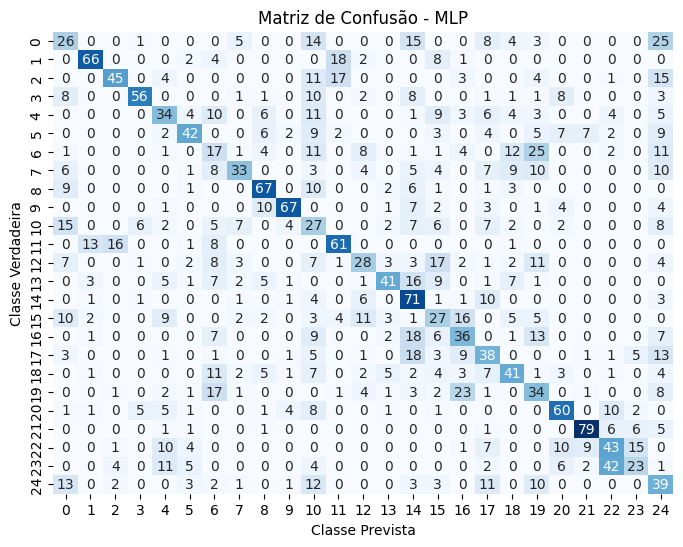

In [280]:
# Obtendo as previsões do modelo
y_pred_mlp = cross_val_predict(
    pipe,
    X,
    y,
    cv=sgkf,
    groups=groups,
    method='predict_proba'
)

# Calculando o f1
f1_macro = f1_score(y, np.argmax(y_pred_mlp, axis=1), average='macro')
print("F1-score macro:", f1_macro)

# Calculando a Matriz de confusão
conf_mat = confusion_matrix(y, np.argmax(y_pred_mlp, axis=1))

# Plotando o gráfico da matriz de confusão
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.title('Matriz de Confusão - MLP')
plt.xlabel('Classe Prevista')
plt.ylabel('Classe Verdadeira')
plt.show()

## Análise comparatôria entre os três modelos

Analisando o f1 score junto com a acurracia e a matriz de confusão, podemos perceber que todos os modelos não tiveram um desempenho tão elevado, mas considerando que como é um problema de multiclassificação, a classificação por chance seria 0.04. O que significa que os modelos estão realmente conseguindo analisar e classificar os sinais.

Analisando a matriz de confusão, é possível perceber que existem algums sinais especificos e alguns interpretes que os modelos possuem muita dificuldade de prever, o que explicaria os modelos não possuirem um desempenho tão alto.

Em relação a comparação do desempenho entre os modelos, olhando o gráfico abaixo, podemos perceber que o melhor modelo foi o RandomForest, seguido próximo do MLP. O pior modelo foi o Knn, que por ser um modelo mais simples e por se sair melhor em situações com menor quantidade de features, faz sentido ter obtido um desempenho bem pior em comparação aos outros modelos.

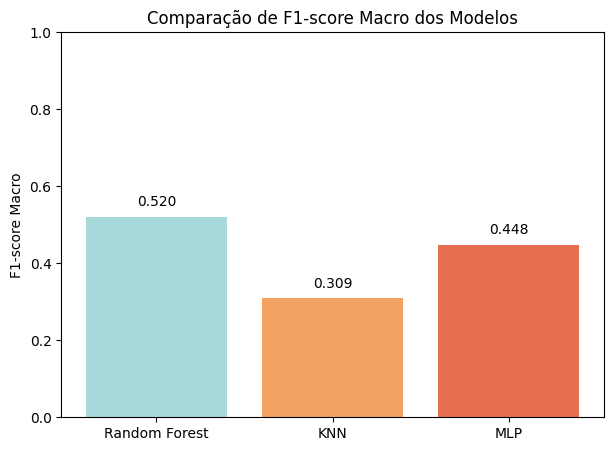

In [288]:
# Calcular F1-score macro para cada modelo
f1_rf = f1_score(y, np.argmax(y_pred_rf, axis=1), average='macro')
f1_knn = f1_score(y, np.argmax(y_pred_knn, axis=1), average='macro')
f1_mlp = f1_score(y, np.argmax(y_pred_mlp, axis=1), average='macro')

# Dados para plotagem
models = ['Random Forest', 'KNN', 'MLP']
f1_scores = [f1_rf, f1_knn, f1_mlp]

cores = ['#A8DADC', '#F4A261', '#E76F51']
plt.figure(figsize=(7,5))
bars = plt.bar(models, f1_scores, color= cores)
plt.title('Comparação de F1-score Macro dos Modelos')
plt.ylabel('F1-score Macro')
plt.ylim(0, 1)

# Adicionar os valores numericamente em cima das barras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f"{yval:.3f}", ha='center', va='bottom')

plt.show()

# Análise dos Algoritmos Não Supervisionados

## Analisando Outliers

Como os algoritmos não supervisionados não precisam que os dados sejam dividos entre treino e teste. É possível manipular a base de dados mais livremente antes de executa-los. Escolhi usar o Isolation Forest para a analise de outliers por ele ser mais adequado quando a base de dados possui muitas features.

In [289]:
# Inicializa e ajusta o Isolation Forest
iso_forest = IsolationForest(contamination='auto', random_state=35)
iso_forest.fit(X)

# Prediz quais amostras são outliers
outlier_pred = iso_forest.predict(X)

# Outliers são marcados como -1, normais como 1
num_outliers = (outlier_pred == -1).sum()
print(f"Número de outliers detectados em X: {num_outliers}")

# Para visualizar os índices dos outliers:
outlier_indices = X.index[outlier_pred == -1]
print("Índices dos outliers:", outlier_indices.tolist())

Número de outliers detectados em X: 16
Índices dos outliers: [146, 303, 440, 1110, 1300, 1636, 1936, 1940, 1952, 1955, 1956, 1957, 2157, 2321, 2339, 2353]


In [290]:
# Obter os índices dos outliers
outlier_indices = X.index[outlier_pred == -1]

# Selecionar apenas as linhas de X_train que são outliers
outliers_table = X.loc[outlier_indices]

# Mostrar a tabela resultante
outliers_table

,id9_x_mean_part1,id9_x_std_part1,id9_x_var_part1,id9_x_mean_part2,id9_x_std_part2,id9_x_var_part2,id9_x_mean_part3,id9_x_std_part3,id9_x_var_part3,id9_x_mean_part4,...,id22_y_var_part5,id22_y_mean_part6,id22_y_std_part6,id22_y_var_part6,id22_y_mean_part7,id22_y_std_part7,id22_y_var_part7,id22_y_mean_part8,id22_y_std_part8,id22_y_var_part8
146,0.581151,0.003516,1.236143e-05,0.577381,1.110223e-16,1.232595e-32,0.578175,0.001316,1.732174e-06,0.583532,...,6.219127e-04,0.380282,0.025514,6.509584e-04,0.462128,0.069672,4.854171e-03,0.931142,0.120416,1.450011e-02
303,0.410484,0.000806,6.503642e-07,0.429032,1.740890e-02,3.030697e-04,0.481855,0.007292,5.316727e-05,0.493952,...,0.000000e+00,0.650371,0.000875,7.658563e-07,0.647100,0.000433,1.875566e-07,0.645156,0.002705,7.314709e-06
440,0.543939,0.007429,5.518825e-05,0.506818,4.738332e-03,2.245179e-05,0.502576,0.000830,6.887052e-07,0.506515,...,1.437234e-04,0.570627,0.011146,1.242254e-04,0.435379,0.032048,1.027088e-03,0.498956,0.048836,2.384910e-03
1110,0.441322,0.001003,1.006546e-06,0.440365,6.710417e-04,4.502970e-07,0.439234,0.000413,1.702804e-07,0.419878,...,2.250973e-03,0.590442,0.052850,2.793145e-03,0.833409,0.070197,4.927553e-03,0.887771,0.001489,2.217256e-06
1300,0.523493,0.008057,6.491801e-05,0.517000,1.708166e-03,2.917831e-06,0.525587,0.006785,4.604030e-05,0.542762,...,2.286237e-06,0.611626,0.144261,2.081125e-02,0.512963,0.027238,7.418839e-04,0.787963,0.078701,6.193892e-03
1636,0.434414,0.002656,7.052163e-06,0.440544,1.014700e-03,1.029616e-06,0.443483,0.004555,2.074746e-05,0.439620,...,2.906013e-04,0.709604,0.130464,1.702096e-02,0.891417,0.004255,1.810887e-05,0.888783,0.000579,3.348482e-07
1936,0.552296,0.003375,1.138848e-05,0.557398,1.124894e-03,1.265387e-06,0.554422,0.000000,0.000000e+00,0.556122,...,1.851831e-03,0.379223,0.017615,3.103029e-04,0.551520,0.171515,2.941743e-02,0.982264,0.034936,1.220525e-03
1940,0.573427,0.000000,0.000000e+00,0.575175,1.748252e-03,3.056384e-06,0.579421,0.001580,2.495007e-06,0.573427,...,6.366563e-03,0.456085,0.029658,8.795946e-04,0.712169,0.184089,3.388875e-02,1.057143,0.010635,1.130987e-04
1952,0.683876,0.001118,1.250378e-06,0.681400,1.118203e-03,1.250378e-06,0.682756,0.001701,2.893235e-06,0.654703,...,3.894497e-04,0.145042,0.032756,1.072934e-03,0.624473,0.261242,6.824716e-02,1.021624,0.006173,3.811043e-05
1955,0.655462,0.003895,1.517379e-05,0.664248,2.415797e-03,5.836073e-06,0.671505,0.004149,1.721642e-05,0.668831,...,3.580222e-05,0.122517,0.003066,9.398084e-06,0.327815,0.200301,4.012042e-02,1.031220,0.061104,3.733725e-03


In [291]:
# --- Removendo os outliers ---
X_clean = X[outlier_pred == 1].copy()

# Se você tem y (labels) correspondente, filtre também:
y_clean = y[outlier_pred == 1].copy()

print("Dimensão original:", X.shape)
print("Dimensão sem outliers:", X_clean.shape)

Dimensão original: (2501, 672)
Dimensão sem outliers: (2485, 672)


## Normalizando a base de dados e aplicando PCA

Todos os algoritmos de clusterização trabalham buscando agrupar os exemplos em categorias. Para que eles façam isso, é preciso que a base de dados esteja normalizada. Além disso, atravéz de analise e vário testes, eu descobri que aplicar PCA para reduzir a dimensionalidade gerou em um resultado melhor para os modelos de clustering.

In [292]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean)

In [293]:
pca = PCA(n_components=0.7)  # manter 70% da variância
X_scaled = pca.fit_transform(X_scaled)

## Aplicando o KMeans

O número de clusters inicial escolhido foi 25 pois existem 25 classes do problema original ( 25 sinais).
O PCA aplicado nos algoritmos abaixo é apenas para facilitar a visualização em um gráfico de 2 dimensões dos agrupamentos realizados pelos algoritmos.

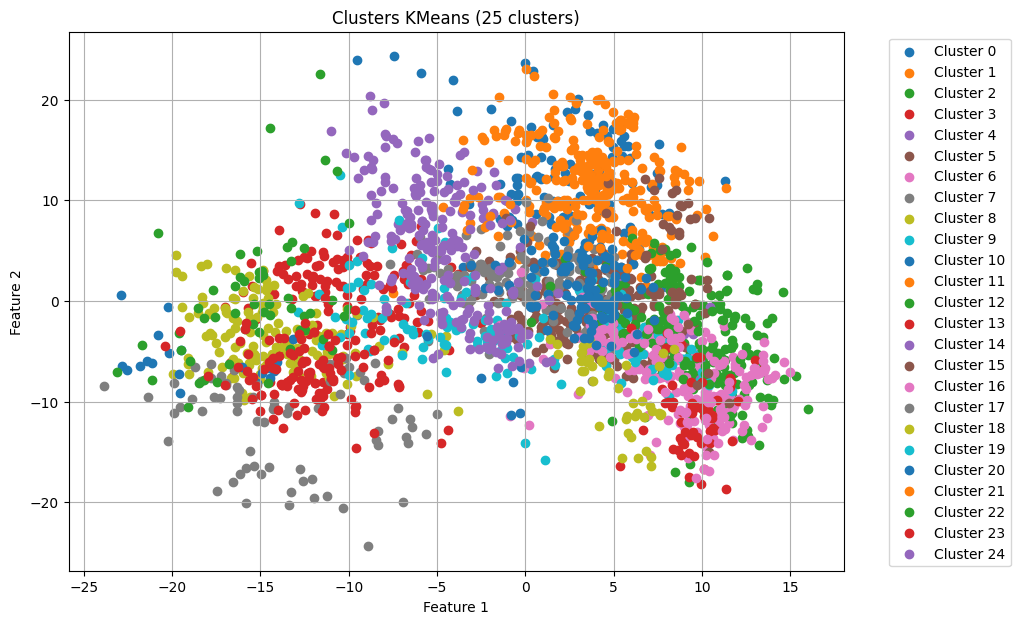

In [294]:
# Aplicando PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Aplicando KMeans com 25 clusters
kmeans = KMeans(n_clusters=25, n_init=50, max_iter=500, random_state=79)
cluster_labels_kmeans = kmeans.fit_predict(X_scaled)

# Adicionar rótudataframelos de cluster ao  original
X_clean['cluster'] = cluster_labels_kmeans

# Visualização simples em 2D (usando as duas primeiras colunas padronizadas)
plt.figure(figsize=(10,7))
for cluster in np.unique(cluster_labels_kmeans):
    plt.scatter(
        X_pca[cluster_labels_kmeans ==cluster, 0],
        X_pca[cluster_labels_kmeans ==cluster, 1],
        label=f'Cluster {cluster}'
    )
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Clusters KMeans (25 clusters)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

In [295]:
silhouette_avg = silhouette_score(X_scaled, cluster_labels_kmeans)
print("Silhouette Score:", silhouette_avg)

db_index = davies_bouldin_score(X_scaled, cluster_labels_kmeans)
print("Davies-Bouldin Index:", db_index)

ch_index = calinski_harabasz_score(X_scaled, cluster_labels_kmeans)
print("Calinski-Harabasz Index:", ch_index)

Silhouette Score: 0.15651501837385162
Davies-Bouldin Index: 1.749432749778133
Calinski-Harabasz Index: 151.71513065609835


## Analisando como o algoritmo agrupou os clusters comparado com o valores do target dos sinais.

In [296]:
# Gera a tabela de contingência: linhas = cluster, colunas = classe alvo
tabela = pd.crosstab(X_clean['cluster'],
                     df[target_column])

tabela.index.name = 'cluster_kmeans'

tabela

Sinal,Adição,Aluno,Antropologia,Apontador,Apostila,Biologia,Bolsa de Estudos,Capítulo,Classe,Coerência,...,Dicionário,Disciplina,Ensinar,Escola,Estudar,Filosofia,Física,Geografia,História,Ângulo
cluster_kmeans,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,5,0,0,0,0,...,0,0,0,0,0,46,9,19,13,0
1,0,1,38,0,0,0,0,0,0,0,...,1,0,0,0,1,2,5,39,39,0
2,2,13,1,11,2,0,10,7,6,10,...,5,6,0,8,3,0,0,0,0,4
3,2,0,0,3,2,0,7,13,9,10,...,13,5,8,11,4,0,0,0,0,6
4,0,0,0,0,0,0,0,0,0,0,...,0,0,9,0,1,0,0,0,0,0
5,13,1,0,24,10,0,8,1,1,10,...,19,13,14,19,14,0,0,0,0,15
6,5,2,1,7,11,0,17,2,11,3,...,8,14,4,13,2,0,0,0,0,12
7,4,0,0,3,14,1,5,0,0,0,...,1,12,39,3,33,0,0,0,0,4
8,8,6,11,12,12,4,10,10,0,10,...,7,10,0,4,0,0,0,0,0,8


## Hierárquico

### Hierárquico com linkage = ward

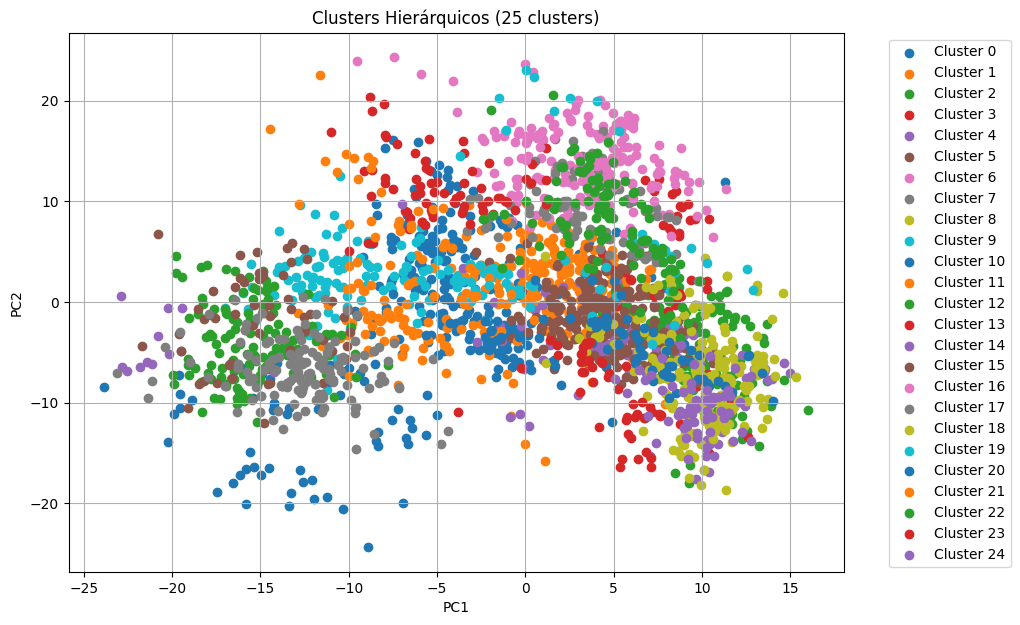

In [297]:
# Aplicando PCA para visualização do gráfico em 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Aplicando clusterização hierárquica com 25 clusters
hierarchical = AgglomerativeClustering(n_clusters=25, linkage='ward')
cluster_labels_hc_ward = hierarchical.fit_predict(X_scaled)

# Adicionar rótulos de cluster ao dataframe original
X_clean['cluster'] = cluster_labels_hc_ward

# Visualização simples em 2D (usando as duas primeiras componentes do PCA)
plt.figure(figsize=(10,7))
for cluster in np.unique(cluster_labels_hc_ward):
    plt.scatter(
        X_pca[cluster_labels_hc_ward==cluster, 0],
        X_pca[cluster_labels_hc_ward==cluster, 1],
        label=f'Cluster {cluster}'
    )
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Clusters Hierárquicos (25 clusters)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


In [ ]:
#Calculando as métricas de avaliação dos algoritmos de clustering
silhouette_avg = silhouette_score(X_scaled, cluster_labels_hc_ward)
print("Silhouette Score:", silhouette_avg)

db_index = davies_bouldin_score(X_scaled, cluster_labels_hc_ward)
print("Davies-Bouldin Index:", db_index)

ch_index = calinski_harabasz_score(X_scaled, cluster_labels_hc_ward)
print("Calinski-Harabasz Index:", ch_index)

### Hierárquico com linkage = Complete

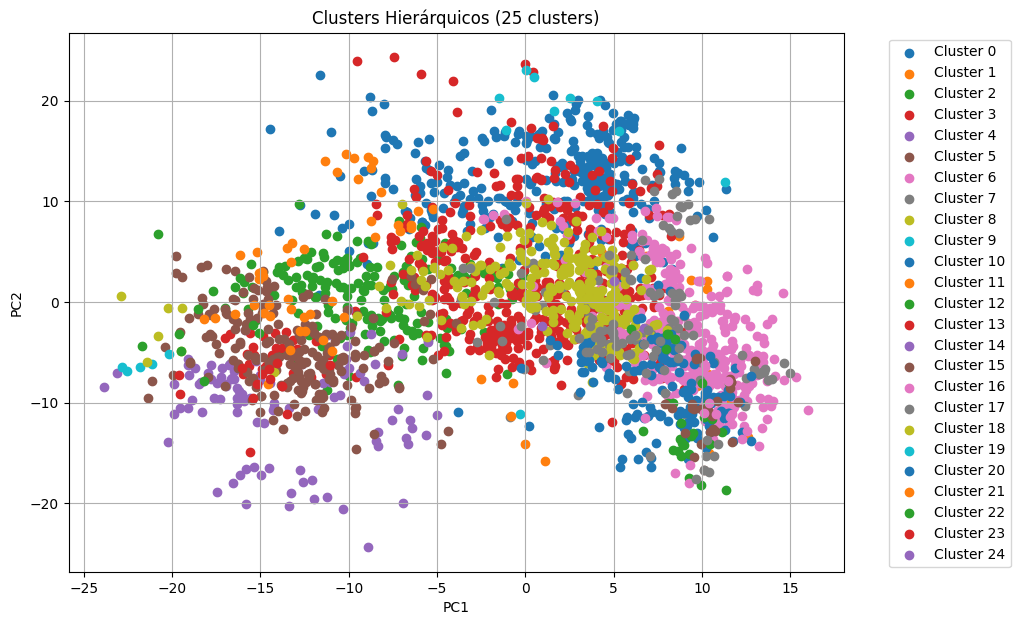

In [298]:
# Aplicando PCA para visualização do gráfico em 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Aplicando clusterização hierárquica com 25 clusters
hierarchical = AgglomerativeClustering(n_clusters=25, linkage='complete')
cluster_labels_hc_completed = hierarchical.fit_predict(X_scaled)

# Adicionar rótulos de cluster ao dataframe original
X_clean['cluster'] = cluster_labels_hc_completed

# Visualização simples em 2D (usando as duas primeiras componentes do PCA)
plt.figure(figsize=(10,7))
for cluster in np.unique(cluster_labels_hc_completed):
    plt.scatter(
        X_pca[cluster_labels_hc_completed==cluster, 0],
        X_pca[cluster_labels_hc_completed==cluster, 1],
        label=f'Cluster {cluster}'
    )
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Clusters Hierárquicos (25 clusters)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


In [299]:
#Calculando as métricas de avaliação dos algoritmos de clustering
silhouette_avg = silhouette_score(X_scaled, cluster_labels_hc_completed)
print("Silhouette Score:", silhouette_avg)

db_index = davies_bouldin_score(X_scaled, cluster_labels_hc_completed)
print("Davies-Bouldin Index:", db_index)

ch_index = calinski_harabasz_score(X_scaled, cluster_labels_hc_completed)
print("Calinski-Harabasz Index:", ch_index)

Silhouette Score: 0.10830075616334252
Davies-Bouldin Index: 1.590278403496377
Calinski-Harabasz Index: 93.31307227216747


## Implementando Kmeans com teste do cotovelo

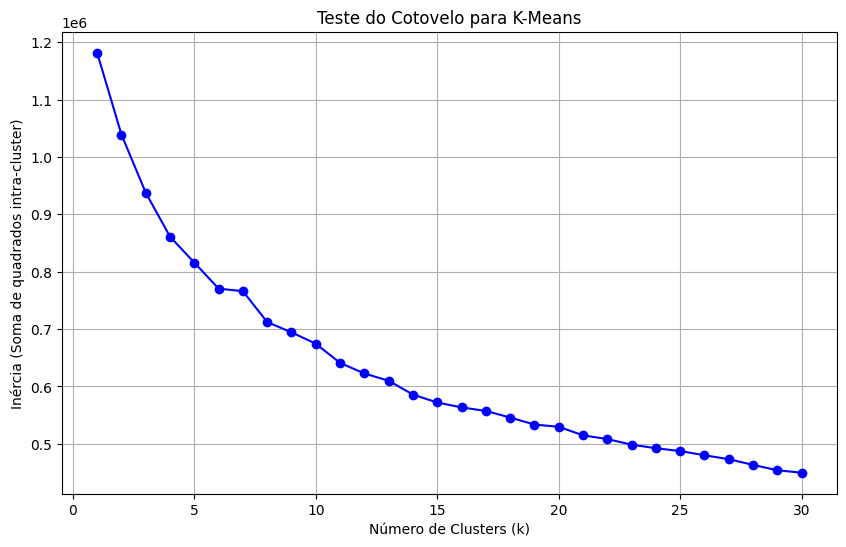

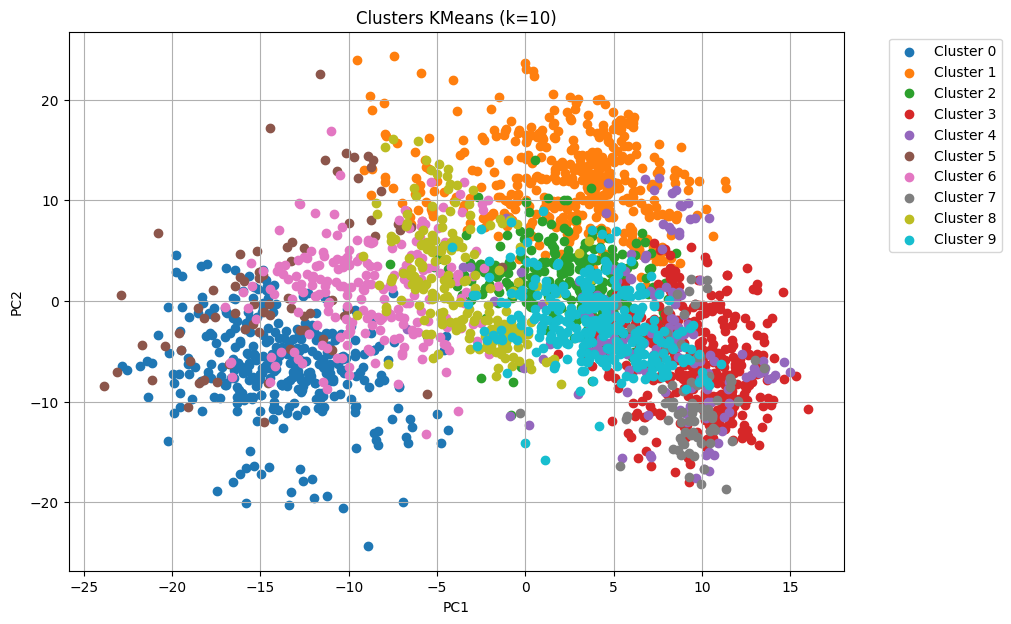

In [300]:
# Aplicando PCA para visualização do gráfico 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Teste do Cotovelo para encontrar número ideal de clusters
inertia_values = []
K_range = range(1, 31)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=79)
    kmeans.fit(X_scaled)
    inertia_values.append(kmeans.inertia_)

# Plot do cotovelo
plt.figure(figsize=(10,6))
plt.plot(K_range, inertia_values, 'o-', color='blue')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia (Soma de quadrados intra-cluster)')
plt.title('Teste do Cotovelo para K-Means')
plt.grid(True)
plt.show()

# Aplicar KMeans com o número de clusters escolhido (exemplo: k=25)
optimal_k = 10
kmeans = KMeans(n_clusters=optimal_k, n_init=50, max_iter=500, random_state=79)
cluster_labels_cotovelo = kmeans.fit_predict(X_scaled)

# Adicionar rótulos de cluster ao dataframe original
X_clean['cluster'] = cluster_labels_cotovelo

# Visualização 2D usando as duas primeiras componentes do PCA
plt.figure(figsize=(10,7))
for cluster in np.unique(cluster_labels_cotovelo):
    plt.scatter(
        X_pca[cluster_labels_cotovelo==cluster, 0],
        X_pca[cluster_labels_cotovelo==cluster, 1],
        label=f'Cluster {cluster}'
    )
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(f'Clusters KMeans (k={optimal_k})')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


In [301]:
#Calculando as métricas de avaliação dos algoritmos de clustering

silhouette_avg = silhouette_score(X_scaled, cluster_labels_cotovelo)
print("Silhouette Score:", silhouette_avg)

db_index = davies_bouldin_score(X_scaled, cluster_labels_cotovelo)
print("Davies-Bouldin Index:", db_index)

ch_index = calinski_harabasz_score(X_scaled, cluster_labels_cotovelo)
print("Calinski-Harabasz Index:", ch_index)

Silhouette Score: 0.15180782412974528
Davies-Bouldin Index: 1.7398425454617787
Calinski-Harabasz Index: 226.71805337225575


## Analisando como o algoritmo agrupou os clusters comparado com o valores do target dos sinais.

In [302]:
# Gera a tabela de contingência: linhas = cluster, colunas = classe alvo
tabela = pd.crosstab(X_clean['cluster'],
                     df[target_column])

tabela.index.name = 'cluster_kmeans'

tabela

Sinal,Adição,Aluno,Antropologia,Apontador,Apostila,Biologia,Bolsa de Estudos,Capítulo,Classe,Coerência,...,Dicionário,Disciplina,Ensinar,Escola,Estudar,Filosofia,Física,Geografia,História,Ângulo
cluster_kmeans,,,,,,,,,,,,,,,,,,,,,
0,20,19,20,19,17,18,20,20,20,20,...,19,20,2,8,3,10,9,10,10,20
1,0,5,48,0,0,52,0,0,0,0,...,0,0,1,0,0,62,80,69,67,0
2,12,10,0,7,17,1,11,19,2,9,...,8,18,36,17,41,1,0,0,0,11
3,16,26,15,16,26,6,27,24,13,13,...,18,28,4,19,5,4,0,5,0,21
4,1,9,1,2,6,0,4,0,3,5,...,3,1,24,2,24,2,10,0,1,5
5,9,0,3,4,2,10,3,5,1,4,...,3,1,3,2,4,3,0,1,1,3
6,7,7,1,8,4,0,10,13,16,15,...,19,11,13,13,7,2,1,0,0,7
7,13,8,1,6,1,2,6,7,0,4,...,0,0,2,0,1,0,0,0,1,8
8,10,12,10,10,11,10,10,10,10,10,...,10,8,0,11,0,10,0,10,10,10


## Cluster Hierárquico usando o valor de K do teste do cotovelo

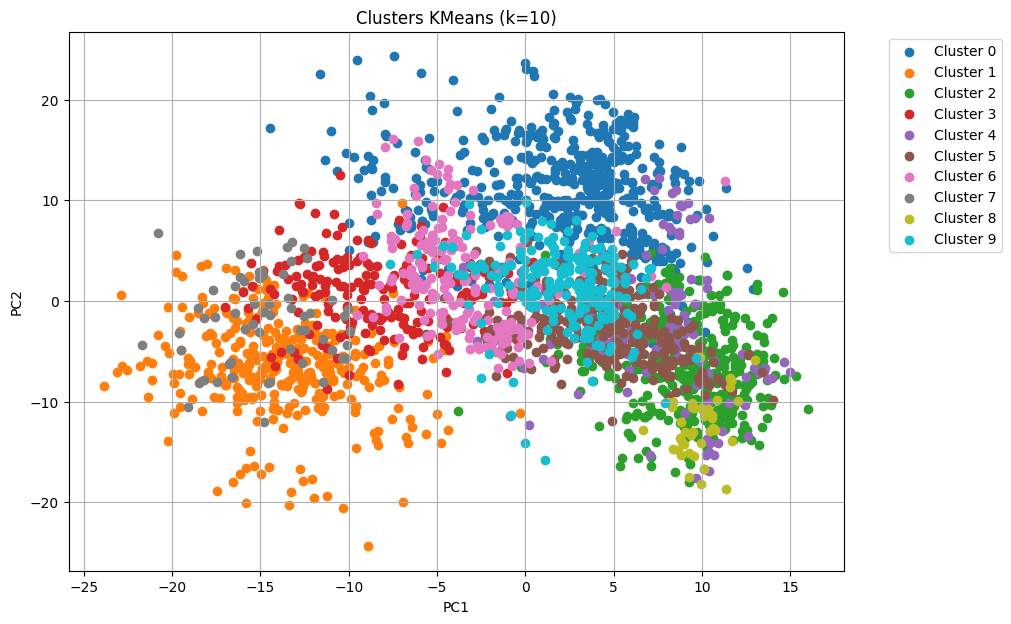

In [303]:
# Aplicando PCA para reduzir para 2 componentes
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Aplicar clusterização hierárquica com a quantidade optimal de clusters
hierarchical = AgglomerativeClustering(n_clusters= optimal_k, linkage='ward')
cluster_labels_hc_cotovelo = hierarchical.fit_predict(X_scaled)

# Adicionar rótulos de cluster ao dataframe original
X_clean['cluster'] = cluster_labels_hc_cotovelo

# Visualização simples em 2D (usando as duas primeiras componentes do PCA)
plt.figure(figsize=(10,7))
for cluster in np.unique(cluster_labels_hc_cotovelo):
    plt.scatter(
        X_pca[cluster_labels_hc_cotovelo==cluster, 0],
        X_pca[cluster_labels_hc_cotovelo==cluster, 1],
        label=f'Cluster {cluster}'
    )
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(f'Clusters KMeans (k={optimal_k})')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


In [304]:
#Calculando as métricas de avaliação dos algoritmos de clustering

silhouette_avg = silhouette_score(X_scaled, cluster_labels_hc_cotovelo)
print("Silhouette Score:", silhouette_avg)

db_index = davies_bouldin_score(X_scaled, cluster_labels_hc_cotovelo)
print("Davies-Bouldin Index:", db_index)

ch_index = calinski_harabasz_score(X_scaled, cluster_labels_hc_cotovelo)
print("Calinski-Harabasz Index:", ch_index)

Silhouette Score: 0.12106507180221829
Davies-Bouldin Index: 1.8222670232477234
Calinski-Harabasz Index: 197.05299037847644


## Comparação entre os modelos de clustering
Analisando os resultados dos algoritmos de clustering como um todo, é possível perceber que eles tiveram um resultado muito pior se comparados com os algoritmos não supervisionados.

Comparando o desempenho dos modelos de clustering entre sí. Podemos perceber que o K means obteve um desempenho relativamente melhor que o do Algoritmo Hierárquico, este que obteve mais sucesso ao usar o linkage = "ward". Interssantemente, ao aplicar o teste do cotovelo e escolher o k = 10, podemos perceber que o algoritmo não teve uma melhoria em relação ao silhouette scor, mas eles tiveram uma melhora no Calinski-Harabasz Index.

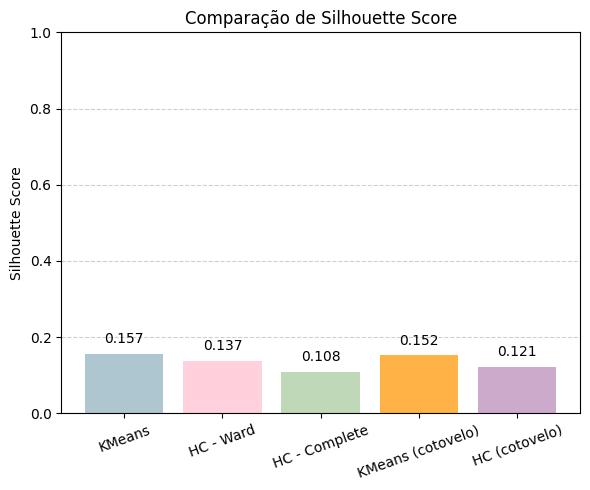

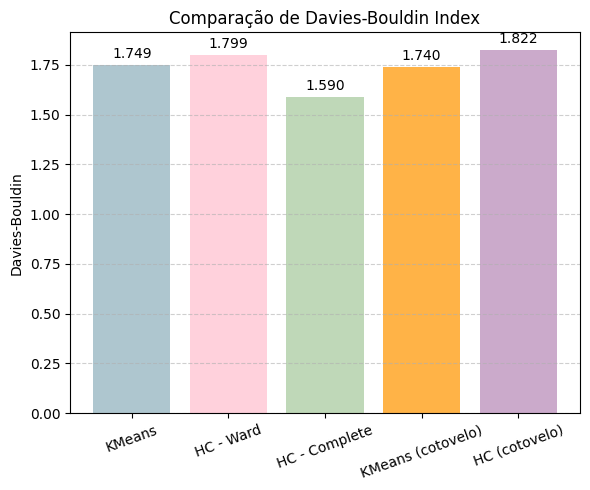

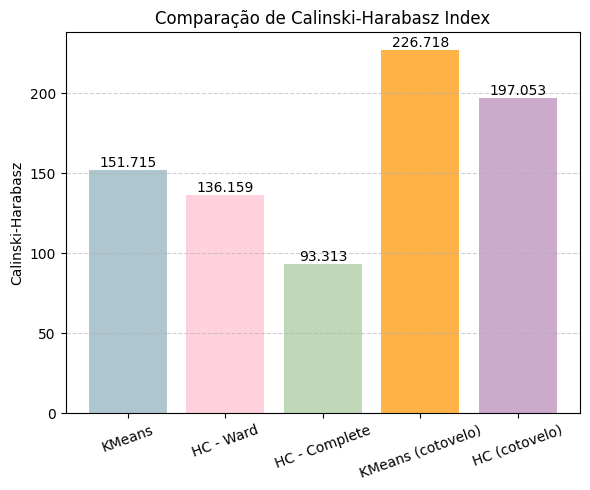

In [305]:
# Dicionário com todos os rótulos de cluster
clusterings = {
    "KMeans": cluster_labels_kmeans,
    "HC - Ward": cluster_labels_hc_ward,
    "HC - Complete": cluster_labels_hc_completed,
    "KMeans (cotovelo)": cluster_labels_cotovelo,
    "HC (cotovelo)": cluster_labels_hc_cotovelo
}

cores = ["#AEC6CF", "#FFD1DC", "#BFD8B8", "#FFB347", "#CBAACB"]

# Calcula cada métrica
sil_scores = {k: silhouette_score(X_scaled, v) for k, v in clusterings.items()}
db_scores  = {k: davies_bouldin_score(X_scaled, v) for k, v in clusterings.items()}
ch_scores  = {k: calinski_harabasz_score(X_scaled, v) for k, v in clusterings.items()}

# Função auxiliar para criar gráfico de barras
def plot_bar(scores, title, ylabel, y_lim=None, invert_y=False):
    plt.figure(figsize=(6, 5))
    plt.bar(scores.keys(), scores.values(), color=cores)
    if y_lim:
        plt.ylim(y_lim)
    if invert_y:
        plt.gca().invert_yaxis()
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(rotation=20)
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    for i, v in enumerate(scores.values()):
        plt.text(i, v + (0.02 if not invert_y else -0.02), f"{v:.3f}", ha="center",
                 va="bottom" if not invert_y else "top")
    plt.tight_layout()
    plt.show()

# Gráficos
plot_bar(sil_scores, "Comparação de Silhouette Score", "Silhouette Score", y_lim=(0, 1))
plot_bar(db_scores,  "Comparação de Davies-Bouldin Index", "Davies-Bouldin")
plot_bar(ch_scores,  "Comparação de Calinski-Harabasz Index", "Calinski-Harabasz")
